In [1]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Installing RAPIDS remaining 25.02 libraries
error: a value is required for '--prerelease <PRERELEASE>' but none was supplied
  [possible values: disallow, allow, if-necessary, explicit, if-necessary-or-explicit]

For more information, try '--help'.

        ***********************************************************************
        The pip install of RAPIDS is complete.

        Please do not run any further installation from the conda based installation methods, as they may cause issues!

        Please ensure that you're pulling from the git repo to remain updated with the latest working install scripts.

        Troubleshooting:
            - If there is an installation failure, please check back on RAPIDSAI owned templates/notebooks to see how to update your personal files.
            - If an installation failure persists when using the latest script, please make an issue on https://gith

In [2]:
# Install scikit-learn if not already installed
!pip install scikit-learn

#import prerequisites
import os
import gc
import pandas as pd
import matplotlib.pyplot as plt
import cudf
from cuml import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
# list .labeled files available in the folder
files = [f for f in os.listdir("/content/drive/MyDrive/Pcap Data Processed") if f.endswith(".labeled")]
print('\n'.join(map(lambda i_v: f"{i_v[0]}: {i_v[1]}", enumerate(files))))
# Replace 'your_folder' and 'your_file.labeled' with the actual path
# Change the index value manually in the line below to choose the file to be processed
file_name = files[4]
file_path = str("/content/drive/MyDrive/Pcap Data Processed/" + file_name)
print(file_path)

0: Malware_7.labeled
1: Honeypot_5.labeled
2: Malware_1.labeled
3: Malware_3.labeled
4: Malware_8.labeled
5: Malware_20.labeled
6: Malware_21.labeled
7: Malware_33.labeled
8: Malware_36.labeled
9: Malware_39.labeled
10: Malware_42.labeled
11: Malware_44.labeled
12: Malware_48.labeled
13: Malware_49.labeled
14: Malware_52.labeled
15: Malware_60.labeled
/content/drive/MyDrive/Pcap Data Processed/Malware_8.labeled


In [4]:
def read_and_parse_label_file(path_to_label_file: str)-> pd.DataFrame:

    df = pd.read_csv(path_to_label_file,
                 sep = '\x09',
                 header = 6,
                index_col = False
                )

    # cutting off header detail row and the last row
    trimmed_df = df[1:-1].copy()

    trim_cols = list(trimmed_df.columns)[1:] # excluding the #fields column name

    data = trimmed_df.iloc[:, :-1].copy() # excluding the last column

    # creating a dictionary to rename the columns
    rename_cols_dic = {}

    for old_col, new_col in zip(data.columns, trim_cols):
        rename_cols_dic[old_col] = new_col

    # renaming the columns
    data = data.rename(columns = rename_cols_dic).copy()


    # splitting this column into three new columns
    last_cols = data['tunnel_parents   label   detailed-label'].str.split('  ', expand = True)

    # renaming the newly split columns
    last_cols.rename(columns = {0:'tunnel_parents', 1:'label', 2: 'detailed-label'}, inplace = True)

    # merging the newly split columns onto the main df

    merge_df = data.merge(last_cols, left_index = True, right_index = True)

    # dropping the columns that was used to split into three

    final_df = merge_df.drop(columns = ['tunnel_parents   label   detailed-label']).copy()

    # Memory-saving measures
    del df, trimmed_df, data, last_cols, merge_df
    gc.collect()

    # Replace hyphens with -1 in all columns
    final_df = final_df.replace('-', '-1')

    return final_df

In [5]:
# import and process the df
try:
    # Attempt to read the file directly as a labeled file
    df = read_and_parse_label_file(file_path)

except Exception as e:
        print(f"Error reading the file: {e}")
        exit()

# Trigger garbage collection to remove var storage from the parse function
gc.collect()

# Specify data types for each column
data_type_map = {
    'id.orig_p': int,
    'id.resp_p': int,
    'proto': str,
    'service': str,
    'duration': float,
    'orig_bytes': int,
    'resp_bytes': int,
    'conn_state': str,
    'missed_bytes': int,
    'history': str,
    'orig_pkts': int,
    'orig_ip_bytes': int,
    'resp_pkts': int,
    'resp_ip_bytes': int,
    'label':str
}

# Remove columns that are not useful or don't contain sufficient data
# More details on reasons for removal are in our full report
columns_to_remove = ['ts', 'uid', 'id.orig_h', 'id.resp_h', 'local_orig', 'local_resp', 'tunnel_parents', 'detailed-label']

# Specify columns to keep
columns_to_keep = []
for col in list(df.columns):
    if col not in columns_to_remove:
        columns_to_keep.append(col)
print(columns_to_keep)

# Copy kept columns to dataframe
df = df[columns_to_keep].copy()

# Following steps necessary as hyphens were markers of no data(NaN) in original csv file
# 1. Replace hyphens with -1 in numeric columns
numeric_columns = [k for k, v in data_type_map.items() if v in (int, float)]
for col in numeric_columns:
    df[col] = df[col].str.strip()  # Remove leading/trailing spaces
    df[col] = pd.to_numeric(df[col].replace('-', '-1'), errors='coerce')

# 2. Replace hyphens with -1 in string columns
string_columns = [k for k, v in data_type_map.items() if v is str]
for col in string_columns:
    df[col] = df[col].str.strip()  # Remove leading/trailing spaces
    df[col] = df[col].str.replace('-', '-1') # Using .str.replace for string columns

# 3. Enforce data types according to data_type_map and fill NaN values
for col, dtype in data_type_map.items():
    if col in df.columns:  # Check if column exists in df
        if dtype == int:
            df[col] = df[col].fillna(-1).astype(int)  # Fill NaN with -1 and cast to int
        elif dtype == float:
            df[col] = df[col].fillna(-1.0).astype(float)  # Fill NaN with -1.0 and cast to float
        elif dtype == str:
            df[col] = df[col].fillna('-1')  # Fill NaN with '-1' in string columns
        else:  # For other types
            df[col] = df[col].astype(dtype, errors='ignore')  # Attempt type casting, ignore errors


['id.orig_p', 'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'label']


In [6]:
# Encode data, select subset,

# Separate features (X) and target variable (y)
X = df[['id.orig_p', 'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes']]
y = df['label']

# Encode string data
le = LabelEncoder()

# Use .loc to update the columns in the copied DataFrames X and y and convert columns to int
X.loc[:, 'conn_state'] = le.fit_transform(X['conn_state'])
X.loc[:, 'conn_state'] = X['conn_state'].astype(int)
X.loc[:, 'proto'] = le.fit_transform(X['proto'])
X.loc[:, 'proto'] = X['proto'].astype(int)
X.loc[:, 'service'] = le.fit_transform(X['service'])
X.loc[:, 'service'] = X['service'].astype(int)
X.loc[:, 'history'] = le.fit_transform(X['history'])
X.loc[:, 'history'] = X['history'].astype(int)

y = le.fit_transform(y)
y = y.astype(int)

# More specific defining requrired due to cudf being more strict
# Specify dtypes for columns
int32_cols = ['id.orig_p', 'id.resp_p', 'proto', 'service', 'orig_bytes',
              'resp_bytes', 'conn_state', 'missed_bytes', 'history',
              'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes']
float32_cols = ['duration']

# Cast columns to their respective dtypes in pandas DataFrame
for col in int32_cols:
    X.loc[:, col] = X[col].astype('int32')
for col in float32_cols:
    X.loc[:, col] = X[col].astype('float32')

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = df[['id.orig_p', 'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes']].columns)

# Convert pandas DataFrames to cuDF DataFrames
X_cudf = cudf.DataFrame.from_pandas(X)
y_cudf = cudf.Series.from_pandas(y)

# Memory-saving measures
del df, y
gc.collect()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cudf, y_cudf, test_size=0.2, random_state=42)

# Memory-saving measures
del X_cudf, y_cudf
gc.collect()

# Initialize and train the SVM model
svm_model = SVC(kernel='linear', verbose=True)  # You can change the kernel if needed
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test.to_numpy(), y_pred.to_numpy())  # Convert to NumPy arrays
print(f"Accuracy of SVM model: {accuracy}")


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


[2025-04-13 02:09:39.763] [CUML] [warning] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.
[2025-04-13 02:09:40.141] [CUML] [debug] Creating working set with 1024 elements
[2025-04-13 02:09:40.191] [CUML] [debug] SMO solver finished after 5 outer iterations, total inner 21 iterations, and diff 0.000660
Accuracy of SVM model: 1.0


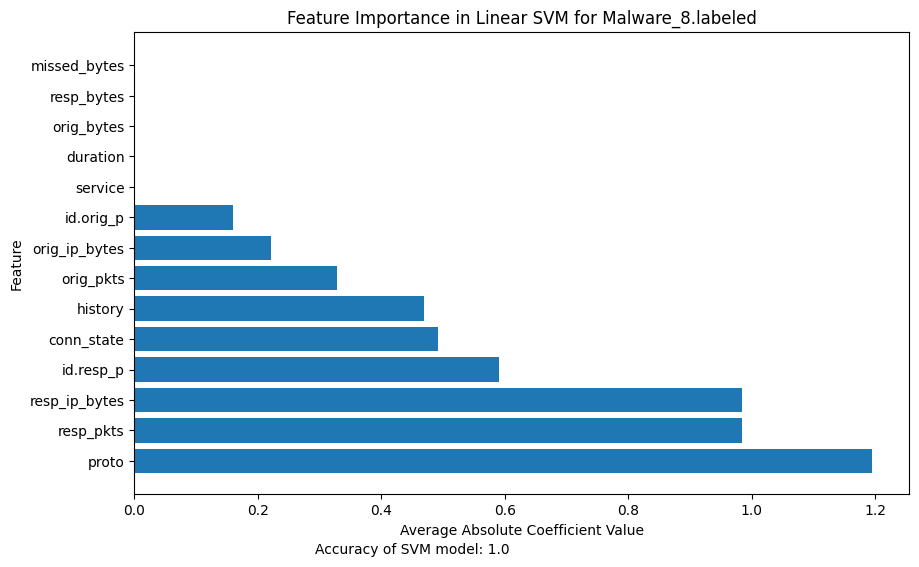

Feature Importance:
           Feature  Importance
2           proto    1.195013
12      resp_pkts    0.983352
13  resp_ip_bytes    0.983352
1       id.resp_p    0.591110
7      conn_state    0.491676
9         history    0.468892
10      orig_pkts    0.327784
11  orig_ip_bytes    0.221560
0       id.orig_p    0.160335
3         service    0.000000
4        duration    0.000000
5      orig_bytes    0.000000
6      resp_bytes    0.000000
8    missed_bytes    0.000000


In [7]:
# Extract coefficients (feature importances)
# Since it's multi-class, get average absolute coefficient values for each feature
coefficients = abs(svm_model.coef_).mean(axis=0)

# Convert the cuDF Series to a NumPy array
coefficients = coefficients.to_numpy()

# Create a cuDF DataFrame for feature importances
feature_names = cudf.Series(X.columns)  # Use X.columns directly
feature_importance = cudf.DataFrame({'Feature': feature_names, 'Importance': coefficients})

# Sort feature importances in descending order
feature_importance_sorted = feature_importance.sort_values(by='Importance', ascending=False)

# Convert to NumPy for plotting with Matplotlib
features_np = feature_importance_sorted['Feature'].to_numpy()
importance_np = feature_importance_sorted['Importance'].to_numpy()

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features_np, importance_np)  # Use barh for horizontal bar plot
title = 'Feature Importance in Linear SVM for ' + file_name
plt.title(title)
plt.xlabel('Average Absolute Coefficient Value')
plt.ylabel('Feature')
plt.figtext(0.5, 0.01, f"\nAccuracy of SVM model: {accuracy}", ha="right", fontsize=10)
plt.show()

print("Feature Importance:\n", feature_importance_sorted)